<a href="https://colab.research.google.com/github/LogicOber/ML4SCI/blob/main/%5BML4Sci%5D_UNet(Release_Version_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subtask 01 - Data Exploration

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [ ]:
# Install the PyDrive wrapper & import libraries.
import re
import tarfile
import shutil
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import wandb

# @markdown Input file name
file_name = "data.tar.gz"  # @param {type:"string"}
file_dir = os.path.join("/content")
file_path = os.path.join(
    file_dir,
    file_name)

# @markdown Choose file source - google drive or sharelink
source_type = "link"  # @param ["drive", "link"] {allow-input: false}

# Use Google link
if source_type == "link":
  print("Accessing file using pydrive from link...")
  # @markdown Copy your google drive file share link here
  google_drive_share_link = 'https://drive.google.com/file/d/1HGbhVpzw29umRrzujk3pogEgGj7GBNOU/view?usp=sharing' # @param {type:"string"}
  file_id = re.search("/d/(.*?)/", google_drive_share_link).group(1)

  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Download file if it doesn't already exist
  if os.path.isfile(file_path):
      print(f'File {file_path} already exists.')
  else:
    print(f'File {file_path} does not exist. Downloading now...')
    downloaded_file = drive.CreateFile({'id': file_id})
    downloaded_file.GetContentFile(file_path)
    print('Download complete.')
# Use Mounted Drive
elif (source_type == "drive"):
  print("Accessing file using pydrive from google drive not impletemented")


# Extract the .tar file
if tarfile.is_tarfile(file_path):
    print('Extracting files...')
    with tarfile.open(file_path, "r") as tar:
        tar.extractall(file_dir)
    print('Extraction complete!')
else:
    print(f"{file_path} is not a valid tar file.")

Accessing file using pydrive from link...
File /content/data.tar.gz does not exist. Downloading now...
Download complete.
Extracting files...
Extraction complete!


## 1.Load data into memory

In [ ]:
def load_data(data_path):
    """
    Loads a dataset from a given file path.

    Args:
        data_path (str): The path to the data file, expected to be a NumPy `.npy` file containing a dictionary.

    Returns:
        dict: The loaded data as a dictionary.
    """

    # YOUR CODE HERE

    return data


In [ ]:
data_path = "/content/data/train/data_02005.npy"

result = load_data(data_path)

for key, item in result.items():
    print(key, item.shape)

field_node (2051, 3)
coord (2051, 2)
edge_index_bi (2, 11858)
cell_node_list (3878, 3)
mask_bd (2051, 1)
mask_wall (2051, 1)
mask_inlet (2051, 1)
mask_outlet (2051, 1)
mask_object (2051, 1)


## 2. Data visulisation

Complete the visulise_data function - the function should be able to plot the physical fields of the data.

A Demo output:
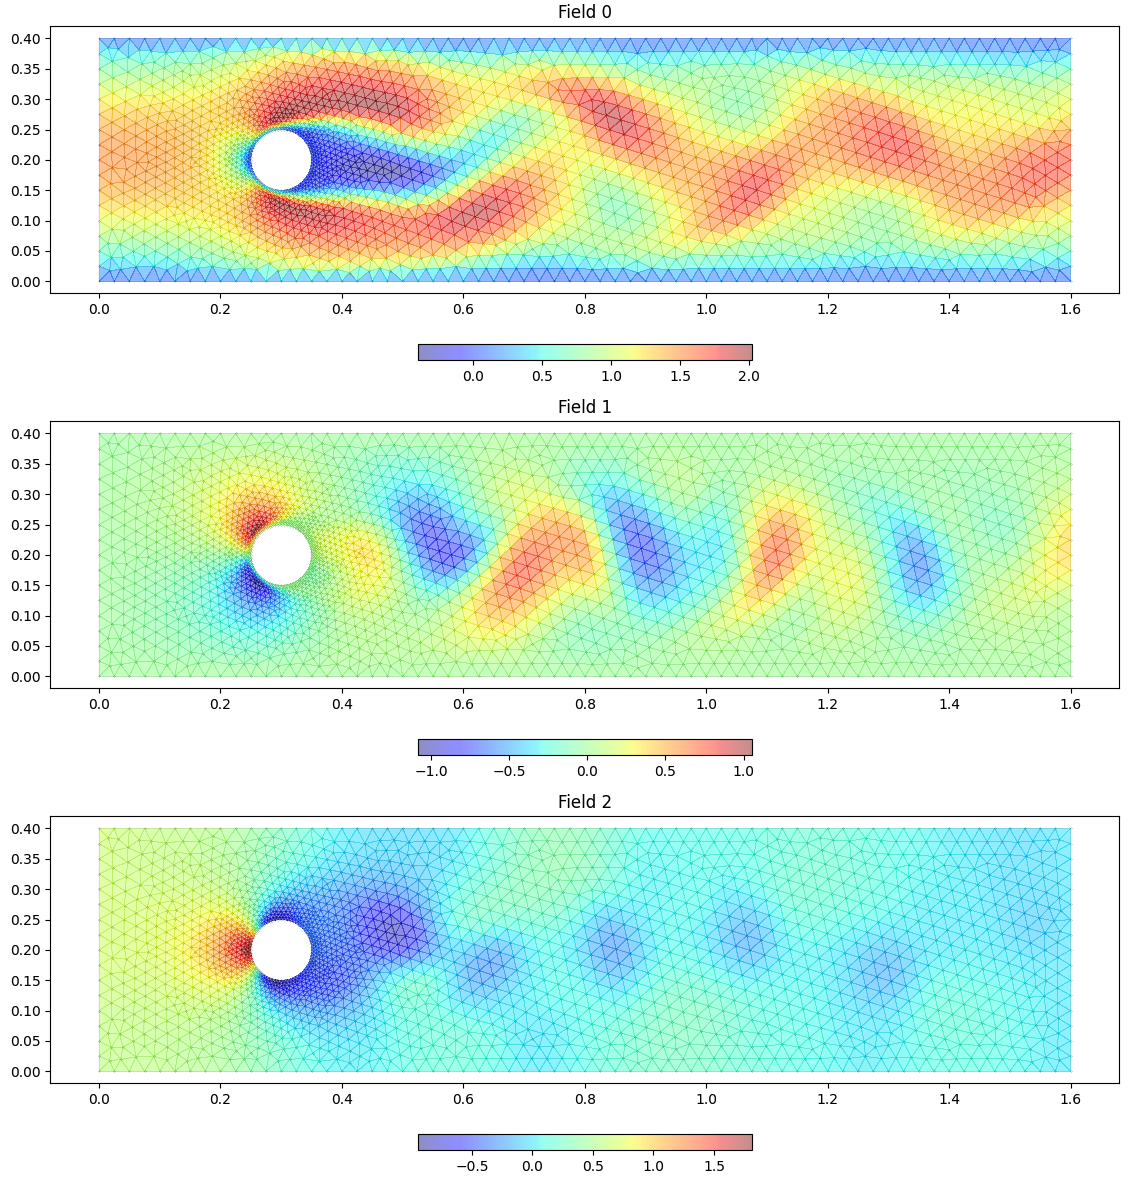

In [ ]:
def visulise_data(data_path, cmap="jet"):
    """
    Visualizes three fields from the dataset in a 3-row subplot.

    Args:
        data_path (str): The path to the `.npy` file containing the dataset.
        cmap (str, optional): The colormap to use for visualization. Default is "jet".

    Returns:
        tuple: A tuple containing the figure (`fig`) and a list of axis (`axes`) objects.
    """

    # YOUR CODE HERE


    return fig, ax


In [ ]:
visulise_data(data_path)

## 3. Data Statistics

In [ ]:
import glob
from natsort import natsorted

In [ ]:
def get_mean_std(data_folder_path):
    """
    Computes the mean and standard deviation of the field node values across multiple dataset files.

    Args:
        data_folder_path (str): The path to the folder containing multiple `.npy` dataset files.

    Returns:
        tuple: A tuple containing:
            - `mean` (numpy.ndarray): The mean values computed across all datasets.
            - `std` (numpy.ndarray): The standard deviation values computed across all datasets.
    """

    # YOUR CODE HERE


    return mean, std



In [ ]:
get_mean_std("/content/data/train/")

## 4.Data interpolation and masking

The grid_data should have shape:(3, 80, 320)

In [ ]:
from scipy.interpolate import griddata

def get_grid_and_mask(data):
    """
    Generates a structured grid and a corresponding mask for the given dataset.

    Args:
        data (dict): A dictionary containing simulation data, with keys:
            - "coord": A NumPy array of shape (N, 2) representing the coordinates of nodes.
            - "field_node": A NumPy array of shape (N, D) containing field values for each node.

    Returns:
        tuple: A tuple containing:
            - `grid_data` (numpy.ndarray): The interpolated field data on a structured grid.
            - `mask_grid` (numpy.ndarray): A binary mask indicating regions within a circular mask.

    Task:
    - Define grid parameters:
        - `grid_num_x`, `grid_num_y`: The number of grid points in the x and y directions.
        - `x_min`, `x_max`, `y_min`, `y_max`: Determine the bounding box of the data.
    - Create a structured grid using `numpy.meshgrid` and flatten the coordinates.
    - Compute a circular mask based on distance from a predefined center (`x_center`, `y_center`) with radius `r`.
    - Interpolate the field values using `scipy.interpolate.griddata`:
        - Loop over each field dimension and interpolate onto the grid using cubic interpolation.
        - Apply the mask by setting masked grid values to zero.
    - Reshape the interpolated grid data into `(num_dim, grid_num_y, grid_num_x)`.
    - Reshape the mask into `(1, grid_num_y, grid_num_x)`.
    """

    # YOUR CODE HERE

    return grid_data, mask_grid


Then we will use the `get_grid_and_mask` function to pre-process the dataset - we read the original data in the first place, process it and save the processed data in-place.

In [ ]:
from tqdm import tqdm

def post_process(dataset_dir = "../data/data/Re_00100/train/"):
    file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
    file_names = natsorted(file_names)

    for file_name in tqdm(file_names, desc="Processing files"):
        data = load_data(file_name)
        grid_data, mask = get_grid_and_mask(data)
        data["field_conv"] = grid_data
        data["mask"] = mask
        np.save(file_name, data)

In [ ]:
post_process(dataset_dir = "/content/data/train/")

Processing files: 100%|██████████| 3000/3000 [07:17<00:00,  6.86it/s]


In [ ]:
post_process(dataset_dir = "/content/data/test/")

Processing files: 100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


In [ ]:
post_process(dataset_dir = "/content/data/val/")

Processing files: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


(3, 80, 320)


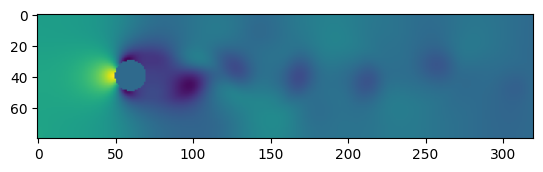

In [ ]:
data = load_data(data_path)

grid_data = data["field_conv"]
print(grid_data.shape)
plt.imshow(grid_data[2])
plt.show()

(1, 80, 320)


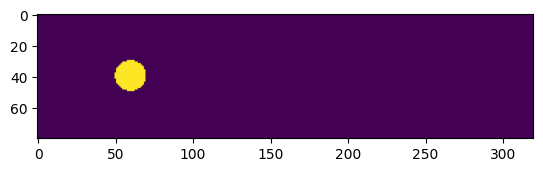

In [ ]:
mask_data = data["mask"]
print(mask_data.shape)
plt.imshow(mask_data[0])
plt.show()

# Subtask 02 - Dataset construction and Data Loading

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from natsort import natsorted
from scipy.interpolate import griddata

Please bear in mind this is time-sequence-like dataset: each entry of the dataset should contain a input (previous time step) and a ouput (later time step)

In [ ]:
class CNNDataset(Dataset):
    """
    A custom PyTorch dataset class for loading sequential data samples from `.npy` files.

    Args:
        dataset_dir (str, optional): Path to the directory containing `.npy` dataset files.
        transform (callable, optional): A function to apply transformations to input data.
        target_transform (callable, optional): A function to apply transformations to target data.

    Attributes:
        file_names (list): A sorted list of file paths to dataset files.
        transform (callable): Transformation function for input data.
        target_transform (callable): Transformation function for target data.

    Task:
    - Load all `.npy` dataset file names from `dataset_dir` matching `"data_*.npy"`.
    - Sort the file names using `natsorted`.
    - Implement `__len__`:
        - Return dataset length.
    - Implement `load_data`:
        - Load an individual dataset file using `numpy.load`.
    - Implement `__getitem__`:
        - Retrieve input and output data pairs:
            - Compute `in_idx` (even index) and `out_idx` (odd index).
            - Ensure `out_idx` is within the dataset range.
            - Load the corresponding `.npy` files using `load_data`.
        - Apply transformations (`transform`, `target_transform`) if provided.
        - Return the input and target data as a tuple.
    """

    def __init__(self, dataset_dir=None, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

        self.file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
        self.file_names = natsorted(self.file_names)

    def __len__(self):
        # YOUR CODE HERE
        return length

    def load_data(self, data_path):
        # YOUR CODE HERE
        return data

    def __getitem__(self, idx):
        # YOUR CODE HERE

        return in_data, out_data


In [ ]:
dataset_dir = "/content/data/test/"

dataset = CNNDataset(dataset_dir)
print(len(dataset))

idx = 248
sample, target = dataset[idx]

250


## 2. Data Transformation

In [ ]:
class Normalise:
    """
    A transformation class to normalize dataset values using precomputed mean and standard deviation.

    Args:
        mean (numpy.ndarray): The mean values for normalization.
        std (numpy.ndarray): The standard deviation values for normalization.

    Attributes:
        mean (numpy.ndarray): Stored mean values.
        std (numpy.ndarray): Stored standard deviation values.

    Task:
    - Implement the `__init__` method:
        - Store the `mean` and `std` values as instance attributes.
    - Implement the `__call__` method:
        - Normalize the `"field_node"` values in `data` using std and mean calculated before
        - Return the updated `data` dictionary.
    """

    def __init__(self, mean, std):
        # YOUR CODE HERE

    def __call__(self, data):
        # YOUR CODE HERE
        return data



class ToFloatTransform:
    def __init__(self, scale=True):
        return

    def __call__(self, data):
        data["field_conv"] = torch.from_numpy(data["field_conv"]).float()
        return data


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for transform in self.transforms:
            data = transform(data)
        return data

In [ ]:
transform = Compose([
    # YOUR CODE HERE - replace [0, 0, 0] with the mean/std you calculated
    Normalise(mean = np.array([[0, 0, 0]]),
              std = np.array([[0, 0, 0]])),
    ToFloatTransform(),
])

dataset = CNNDataset(dataset_dir = dataset_dir, transform=transform, target_transform=transform)

idx = 0
data_in, target = dataset[idx]

conv_in = data_in["field_conv"]

## 3. Data Loader


In [ ]:
Loader = DataLoader(dataset=dataset, num_workers=4, batch_size=16)

# Subtask 03 - UNet

## 1.UNet

This implementation of U-Net is provided as a demonstrative demo to give you a starting point for understanding how encoder-decoder architectures work. Feel free to alter the architecture, adjust hyperparameters, experiment with different activation functions, or modify the number of layers to suit your needs. The goal is to encourage exploration and hands-on learning, so don't hesitate to play around with it and make improvements! 🚀

You might find this helpful when calculating output size:

$$Size_{out} = \lfloor\frac{Size_{in} + 2Padding - Kernel}{Stride}\rfloor + 1$$

In [ ]:
# Make it a task
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class UNet(nn.Module):
    """
    A U-Net implementation for image-to-image tasks with customizable depth and channel configurations.

    Args:
        c_in (int, optional): Number of input channels. Default is 3.
        c_hidden (int, optional): Number of hidden channels. Default is 64.
        c_out (int, optional): Number of output channels. Default is 3.
        dropout (float, optional): Dropout rate for regularization. Default is 0.
        depth (int, optional): Number of encoder/decoder layers. Default is 4.

    Attributes:
        input_layer (nn.Conv2d): The first convolutional layer to process input.
        encoder (nn.ModuleList): A list of convolutional layers forming the encoder.
        bottleneck (nn.Sequential): The bottleneck layer connecting encoder and decoder.
        decoder (nn.ModuleList): A list of transposed convolutional layers forming the decoder.
        output_layer (nn.Conv2d): The final convolutional layer to generate output.

    Task:
    - Implement `__init__`:
        - Define an input layer using `nn.Conv2d`.
        - Construct an encoder with multiple convolutional layers.
        - Define a bottleneck layer to bridge encoder and decoder.
        - Construct a decoder with transposed convolutions for upsampling.
        - Define an output layer using `nn.Conv2d`.
    - Implement `conv`:
        - Create a sequence of convolutional layers, batch normalization, LeakyReLU activations, and dropout.
    - Implement `deconv`:
        - Create a transposed convolutional layer for upsampling.
    - Implement `forward`:
        - Pass input through `input_layer`.
        - Encode the input using `encoder`, storing skip connections.
        - Process the bottleneck layer.
        - Decode using `decoder`, concatenating skip connections.
        - Pass through `output_layer` to generate final output.

    Example:
        >>> model = UNet()
        >>> x = torch.randn(1, 3, 128, 128)
        >>> y = model(x)
        >>> print(y.shape)  # Expected output shape (1, 3, 128, 128)
    """

    def __init__(self, c_in=3, c_hidden=64, c_out=3, dropout=0, depth=4):
        super(UNet, self).__init__()
        # YOUR CODE HERE
        # input layer

        # Encoder

        # Bottleneck

        # Decoder

        # output layer

    def conv(self, in_c, mid_c, out_c, k, s, p, dropout=0):
        # YOUR CODE HERE


    def deconv(self, in_c, out_c):
        # YOUR CODE HERE


    def forward(self, x):
        # YOUR CODE HERE

        return x



In [ ]:
model = UNet()

dummy = torch.randn((1, 3, 320, 80))
model(dummy).shape

torch.Size([1, 3, 320, 80])

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    avg_loss = 0.0
    for batch in loader:
        in_data, out_data = batch
        in_data, out_data = in_data["field_conv"].to(device), out_data["field_conv"].to(device)
        optimizer.zero_grad()
        pred = model(in_data)
        loss = criterion(pred, out_data)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss /= len(loader)
    return loss, model


def test_one_epoch(model, loader, criterion):
    model.eval()
    avg_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            in_data, out_data = batch
            in_data, out_data = in_data["field_conv"].to(device), out_data["field_conv"].to(device)
            pred = model(in_data)
            loss = criterion(pred, out_data)
            avg_loss += loss.item()
    avg_loss /= len(loader)
    return loss




def train(epoch, model, optimizer, loader_train, loader_test):
    criterion = torch.nn.MSELoss()
    model = model.to(device)
    for i in range(epoch):
        loss, model = train_one_epoch(
            model=model, loader=loader_train, optimizer=optimizer, criterion=criterion)
        print(f"Epoch \t{i+1}, Train Loss \t{loss}")
        if (i+1) % 50 == 0:
            info = test_one_epoch(
                model=model, loader=loader_test, criterion=criterion)
            print(f"\t Epoch \t{i+1}, Test Loss \t{loss}")
            model_path = os.path.join(
                os.path.abspath("."),
                f"epoch_{i+1}.pth"
            )
            torch.save(model.state_dict(), model_path)
            print(model_path, "saved")


In [ ]:
# Feel free to experiment with these parameters to see how they affect training!
epoch = 100
lr = 1e-3
bs = 16

model = UNet()

train_set = CNNDataset(
    dataset_dir = "/content/data/train/",
    transform=transform, target_transform=transform)
test_set = CNNDataset(
    dataset_dir = "/content/data/test/",
    transform=transform, target_transform=transform)

loader_train = DataLoader(train_set, batch_size=bs, num_workers=8)
loader_test = DataLoader(test_set, batch_size=bs, num_workers=8)

# Init optimizer
# YOUR CODE HERE
optimizer =

train(epoch=epoch, model=model, optimizer=optimizer, loader_train=loader_train, loader_test=loader_test)

In [ ]:
def load_model(model, weight_path, strict=False):
    """
    Loads pre-trained weights into a PyTorch model from a given file path.

    Args:
        model (torch.nn.Module): The PyTorch model.
        weight_path (str): File path to the pre-trained model weights.

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    try:
        model.load_state_dict(torch.load(weight_path), strict=strict)
    except RuntimeError:
        state_dict = torch.load(weight_path, map_location=device)
        model.load_state_dict(state_dict, strict=strict)
    return model


def denormalise(data, mean, std):
    mean = mean[(...,) + (None,) * (data.ndim - mean.ndim)]
    std = std[(...,) + (None,) * (data.ndim - std.ndim)]
    return data * std + mean


def calc_norm_error(pred, truth, ord=2):
    """
    Compute the relative error of two input. input are supposed to have
    shape of (channel, height, width). Other shape might work but please
    be careful and aware of what you are doing.

    pred: The prediction output by model.
    truth: The ground truth against which error are measured.
    ord: the order of norm.
    """
    pred, truth = [vec.flatten() for vec in [pred, truth]]
    nume = torch.linalg.norm((pred - truth), ord=ord)
    deno = torch.linalg.norm(truth, ord=ord)
    return nume / deno

def calculate_error_and_inference(dataloader, model, mean, std):
    model.to(device)
    model.eval()
    error = 0.0
    pred_list = []
    ground_list = []
    with torch.no_grad():
        for batch in dataloader:
            data_in, target = batch
            data_in, target = data_in["field_conv"], target["field_conv"]
            data_in, target = data_in.to(device), target.to(device)
            pred = model(data_in)
            pred, target = denormalise(pred, mean, std), denormalise(target, mean, std)
            pred_list.append(pred.detach().cpu().numpy())
            ground_list.append(target.detach().cpu().numpy())
            error_i = calc_norm_error(pred, target)
            error += error_i.detach()
    error /= (len(dataloader) * dataloader.batch_size)
    return error, pred_list, ground_list


In [ ]:
model = UNet(c_hidden=64)
model = load_model(model, "./epoch_100.pth")
dataset_test = CNNDataset(
    dataset_dir = "/content/data/test/",
    transform=transform, target_transform=transform)
test_loader = DataLoader(dataset_test, batch_size=1, num_workers=8)

error, pred, ground = calculate_error_and_inference(
    test_loader, model,
     # YOUR CODE HERE - replace [0, 0, 0] with the mean/std you calculated
    mean = torch.tensor([[0, 0, 0]]).to(device),
    std = torch.tensor([[0, 0, 0]]).to(device),
)
print(error)

In [ ]:
def interpolate_back(coord, data, method="cubic"):
    num_dim = data.shape[0]

    grid_num_x = 320
    grid_num_y = 80

    x_min, x_max = min(coord[:, 0]), max(coord[:, 0])
    y_min, y_max = min(coord[:, 1]), max(coord[:, 1])

    x_coord, y_coord = np.meshgrid(
        np.linspace(x_min, x_max, grid_num_x),
        np.linspace(y_min, y_max, grid_num_y)
    )
    coord_grid = np.column_stack((x_coord.flatten(), y_coord.flatten()))

    mesh_data = []
    for i in range(num_dim):
        mesh_data_i = griddata(coord_grid, data[i].flatten(), coord, method=method)
        mesh_data.append(mesh_data_i)
    mesh_data = np.stack(mesh_data, axis=1)

    return mesh_data

def pred_to_df(data):
    reshaped = data.reshape(-1, 3)
    df = pd.DataFrame(reshaped, columns=['Feature_1', 'Feature_2', 'Feature_3'])
    df.index.name = "ROW_ID"
    return df

In [ ]:
# inference on the validation dataset:
dataset_val = CNNDataset(
    dataset_dir = "/content/data/val/",
    transform=transform, target_transform=transform)
val_loader = DataLoader(dataset_val, batch_size=1, num_workers=8)

coord = dataset_val[0][0]["coord"]
face = dataset_val[0][0]["cell_node_list"]

# Prediction
_, pred, ground = calculate_error_and_inference(
    val_loader, model,
    # YOUR CODE HERE - replace [0, 0, 0] with the mean/std you calculated
    mean = torch.tensor([[0, 0, 0]]).to(device),
    std = torch.tensor([[0, 0, 0]]).to(device),
)

# Interpolate back
for i in range(len(pred)):
    print(pred[i].shape)
    pred[i] = interpolate_back(coord, pred[i].squeeze(0))
    ground[i] = interpolate_back(coord, ground[i].squeeze(0))

(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)
(1, 3, 80, 320)


In [ ]:
pred = np.stack(pred, axis=0)
print(pred.shape)

(10, 2051, 3)


The cell below will make a CSV file under the /content folder - download and submit it to the competition!

In [ ]:
import pandas as pd
print(pred.shape)
# save file for submission 1
pred_1 = np.stack(pred, axis=0)
np.save("pred_1.npy", pred_1)
pred_to_df(pred_1).to_csv("pred_1.csv", index=True)

(10, 2051, 3)


Visualise one output sample to check if everything looks good

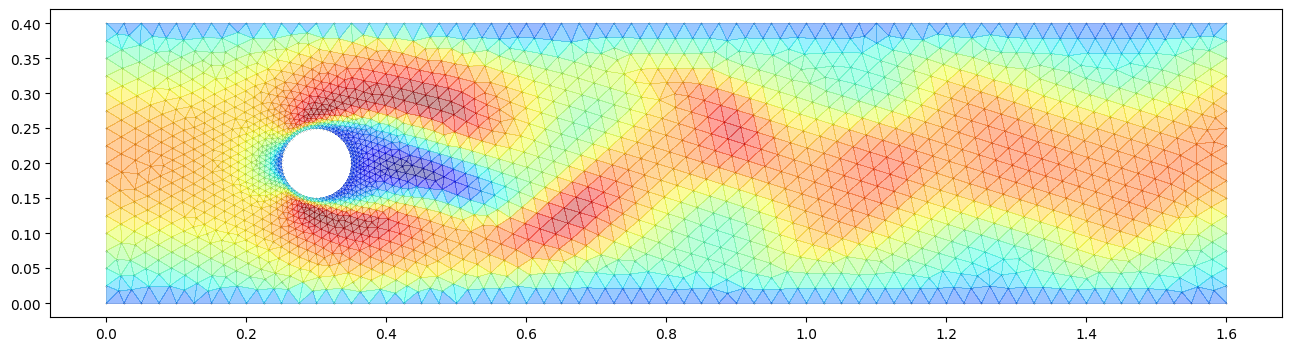

In [ ]:
import matplotlib.tri as tri
cmap = "jet"

left, right = min(coord[:, 0]), max(coord[:, 0])
bottom, top = min(coord[:, 1]), max(coord[:, 1])
value = pred[0, :, 0]

width = zeta * (right - left)
height = zeta * (top - bottom)

triangle = tri.Triangulation(coord[:, 0], coord[:, 1], face)

fig, ax = plt.subplots(figsize=(width, height))

ax.set_aspect("equal")
ax.triplot(triangle, 'ko-', ms=0.1, lw=0.1)
ax.tripcolor(triangle, value, cmap=cmap, alpha=0.4)

# 🔥 Additional Tasks: Experiment and Explore!

- 1️⃣ Investigate Interpolation Methods
  - The griddata function supports different interpolation techniques like "cubic", "linear", and "nearest". Experiment with these and analyze how they impact the quality of the interpolated field.

  - Does "cubic" provide smoother results than "linear"?
  - How does "nearest" compare in terms of accuracy and computation time?
  - Visualize the outputs for different interpolation methods and compare them.


- 2️⃣ Modify and Optimize the U-Net Architecture: The U-Net model provided is a basic version—feel free to tweak it! Try the following:

  - Increase or decrease the depth of the encoder/decoder.
  - Change the number of filters per layer.
  - Experiment with different activation functions like ReLU, LeakyReLU, or GELU.
  - Try batch normalization, dropout, or other regularization techniques to see their effect on performance.
- 3️⃣ Hyperparameter Tuning
  - Test different learning rates (lr), batch sizes (bs), and number of epochs to find the best combination for faster and more stable training. You can even implement learning rate scheduling to improve convergence!

- 4️⃣ Analyze Performance
Once you've tried different interpolation methods and U-Net architectures, compare their performance:

  - How does the choice of interpolation method impact model accuracy?
  - Does a deeper U-Net always perform better, or does it overfit?
  - What trade-offs exist between computational cost and output quality?

💡 Keep experimenting and take notes on your findings. Understanding these trade-offs will help you develop better models in real-world applications! 🚀